In [21]:
#please leave it here otherwise (cuda, gpu card gives me problem)
'''
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #deactivate gpu
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
'''

from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import cupy as cp  # for use GPU
from tensorflow import keras
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

#----- to activate GPU card -----
USE_GPU = False #with True it will use the GPU card
'''
if not USE_GPU:
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
'''

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 3.0.0


In [3]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

if USE_GPU:
    x_train = cp.array(x_train)
    y_train = cp.array(y_train)
    x_test = cp.array(x_test)
    y_test = cp.array(y_test)
    
print(f"N={N}, N_train={N_train}, L={L}")

N=5000, N_train=3750, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 0
[ 24.771  46.131 -49.161 -39.356] 0
[-20.13   15.641  30.981  37.218] 0
[46.465 22.369 14.248 21.745] 0


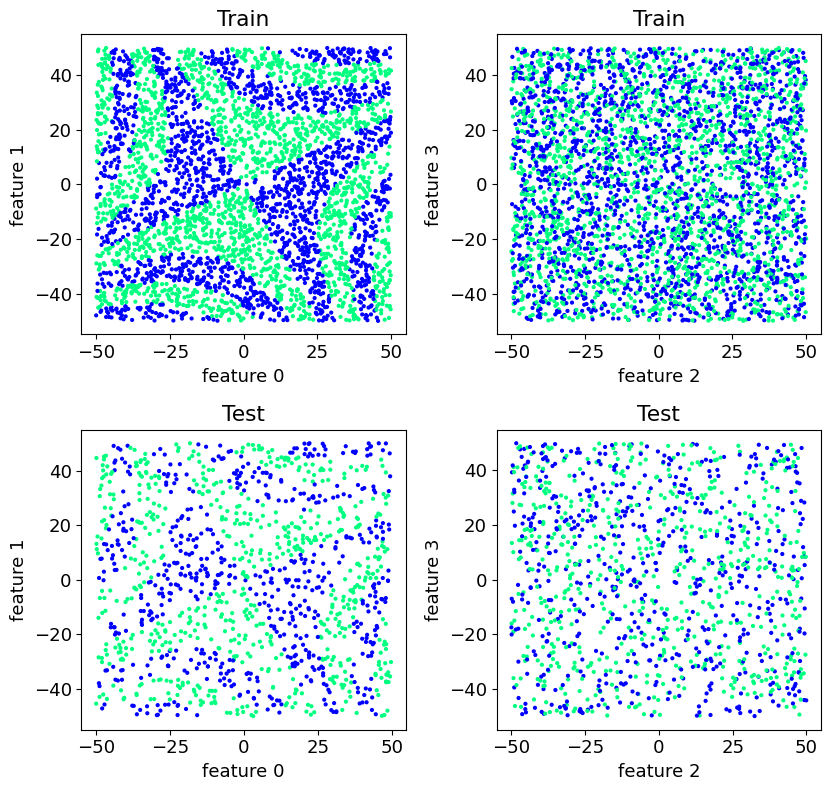

In [4]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [5]:
def classify(clf=GradientBoostingClassifier(),show=False, show_tree=False, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    if show: print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1

    if show:
        y_plot= clf.predict(x_plot)
        fig,AX = plt.subplots(1,2,figsize=(8.2,4))
        scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
        scat(AX[1],x_train[:],y_train,title="training set")
        fig.tight_layout()
        plt.show()
    
    if show_tree:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()
    return 1-clf.score(x_test, y_test),clf.score(x_test, y_test)

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

## XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

errors: 6.64%   Accuracy=0.934


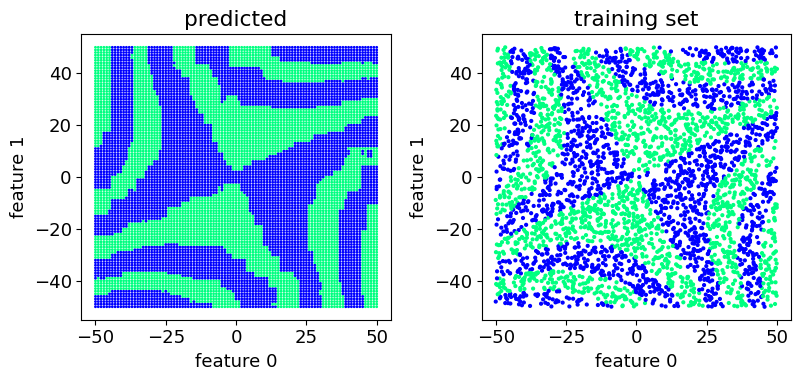

(0.06640000000000001, 0.9336)

In [51]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain",
                      device = "cuda" if USE_GPU else "cpu") #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001, 
       # n_estimators=30)

classify(model, show=True)

gain
[0.41903338 0.4430613  0.06554136 0.07236399]


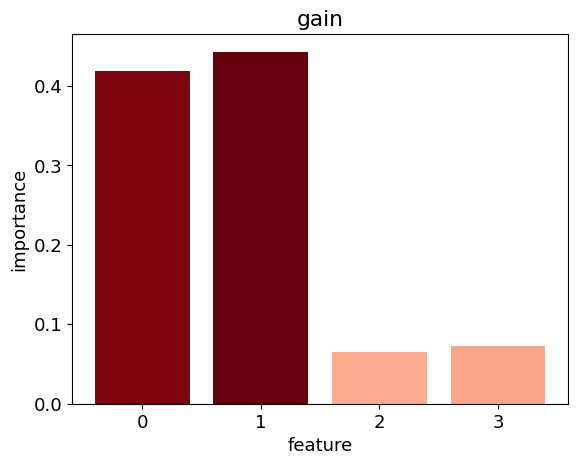

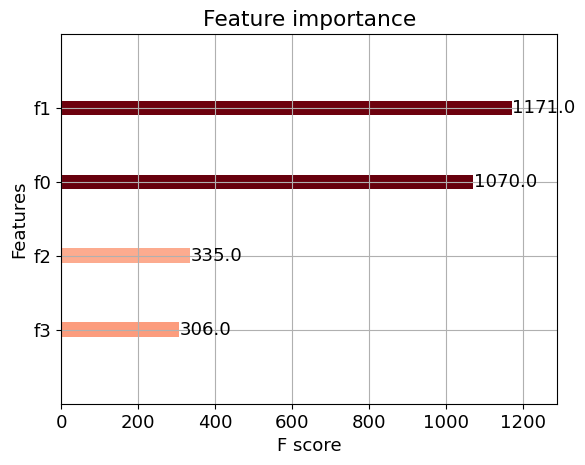

In [52]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance

print(model.importance_type)
print(model.feature_importances_)
# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
plt.show()

Documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html

    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [1070. 1171.  335.  306.]
1 gain [3.84043241 4.06064796 0.6006853  0.6632145 ]
2 total_gain [4109.26269531 4755.01855469  201.22956848  202.94363403]
3 cover [73.71099854 66.86531067 77.84243011 62.61100388]
4 total_cover [78870.765625   78299.28125    26077.21289062 19158.96679688]


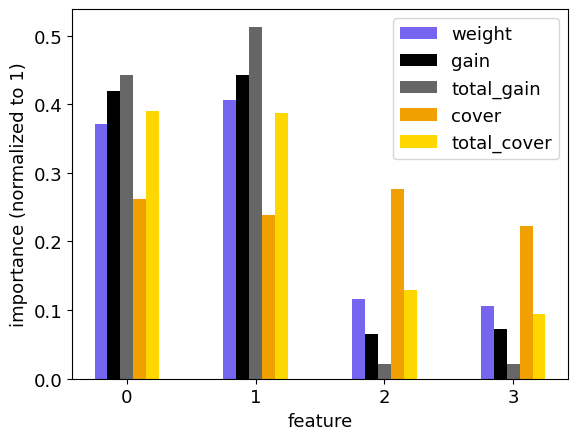

In [53]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

## normal Gradient Boosting

In [54]:
# GradientBoostingClassifier()
classify()

(0.1976, 0.8024)

## AdaBoost

In [55]:
classify(clf=AdaBoostClassifier(learning_rate=.8,n_estimators=150))

/home/marco/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


(0.364, 0.636)

# 1. Model complexity, parameters’ and regularization

In [56]:
def make_and_test_xgb_model(importance_type="gain", learning_rate=0.4 ,reg_lambda=0.001, n_estimators=40, max_depth = 6, gamma = 0):
    model = XGBClassifier(seed=1,
                          objective='binary:logistic',
                          importance_type="gain",#weight, cover, ...
                          learning_rate=learning_rate,
                          reg_lambda=reg_lambda, 
                          n_estimators=n_estimators,
                          max_depth = max_depth,
                          gamma = gamma,
                          n_jobs = -1,
                          #tree_method = "hist",
                          device = "cuda" if USE_GPU else "cpu" )

    err, acc = classify(model)
    return model, acc, err

#### Test varying learning rate and n_range

In [57]:
n_range = np.linspace(10,200,40)
l_range = np.linspace(0.1,1,40)

acc_arr = []
for n in tqdm(n_range, desc = "Processing"):
    acc_row = []
    for l in l_range:
        model, acc, err = make_and_test_xgb_model(importance_type="gain", learning_rate=l ,reg_lambda=0.001, n_estimators=int(n), max_depth = 6, gamma = 0)
        acc_row.append(acc)
    acc_arr.append(acc_row)

f_name = f"Point_1/{float(min(l_range))},{float(max(l_range))},{min(n_range)},{max(n_range)}.npy"
np.save(f_name, acc_arr)
print("File", f_name, "saved correctly")

Processing: 100%|███████████████████████████████████████████████████| 40/40 [02:33<00:00,  3.84s/it]

File Point_1/0.1,1.0,10.0,200.0.npy saved correctly


Code to visualize the saved file

Best accuracy with n_estimators = 44 and learning rate = 0.38


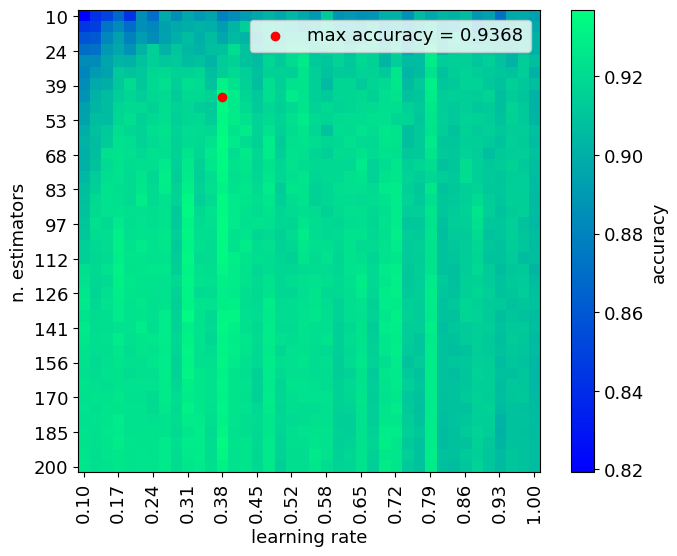

In [8]:
mi_n = 10
ma_n = 200
mi_l = 0.1
ma_l = 1.0

acc_arr_r = np.load(f"Point_1/{mi_l},{ma_l},{float(mi_n)},{float(ma_n)}.npy")

n_range = np.linspace(mi_n,ma_n,len(acc_arr_r), dtype="int")
l_range = np.linspace(mi_l,ma_l,len(acc_arr_r[0]))

max_idx = np.unravel_index(np.argmax(acc_arr_r), acc_arr_r.shape)
max_value = acc_arr_r[max_idx]

best_n_estimators = n_range[max_idx[0]]
best_learning_rate = l_range[max_idx[1]]

print(f"Best accuracy with n_estimators = {best_n_estimators} and learning rate = {best_learning_rate:.2f}")

plt.figure(figsize=(8, 6))
plt.imshow(acc_arr_r)
plt.colorbar(label="accuracy", shrink= 1)

plt.scatter(max_idx[1],max_idx[0], color = "r", label = f"max accuracy = {max_value}")

plt.xlabel("learning rate")
plt.ylabel("n. estimators")
plt.yticks(range(len(n_range)), labels=n_range)
plt.xticks(range(len(l_range)), labels=[f'{val:.2f}' for val in l_range], rotation = 90)
xticks = plt.xticks()[0] 
yticks = plt.yticks()[0]
plt.xticks(xticks[::3])
plt.yticks(yticks[::3])
plt.legend(loc = "best")

plt.show()

#### Test varying gamma and reg_lambda
We use the best combination founded for the learning rate and n_estimators

In [62]:
mi_g = 0
ma_g = 0.02
mi_la = 0.0001
ma_la = 0.005

g_range = np.linspace(mi_g,ma_g,40)
la_range = np.linspace(mi_la,ma_la,40)

acc_arr = []
for g in tqdm(g_range, desc = "Processing"):
    acc_row = []
    for la in la_range:
        model, acc, err = make_and_test_xgb_model(importance_type="gain", learning_rate=best_learning_rate ,reg_lambda=la, n_estimators=best_n_estimators, max_depth = 6, gamma = g)
        acc_row.append(acc)
    acc_arr.append(acc_row)

f_name = f"Point_1/{float(min(la_range))},{float(max(la_range))},{min(g_range)},{max(g_range)}_lambda_and_gamma.npy"
np.save(f_name, acc_arr)
print("File", f_name, "saved correctly")

Processing: 100%|███████████████████████████████████████████████████| 40/40 [01:30<00:00,  2.26s/it]

File Point_1/0.0001,0.005,0.0,0.02_lambda_and_gamma.npy saved correctly


Best accuracy with n_estimators = 0.0 and learning rate = 0.0001


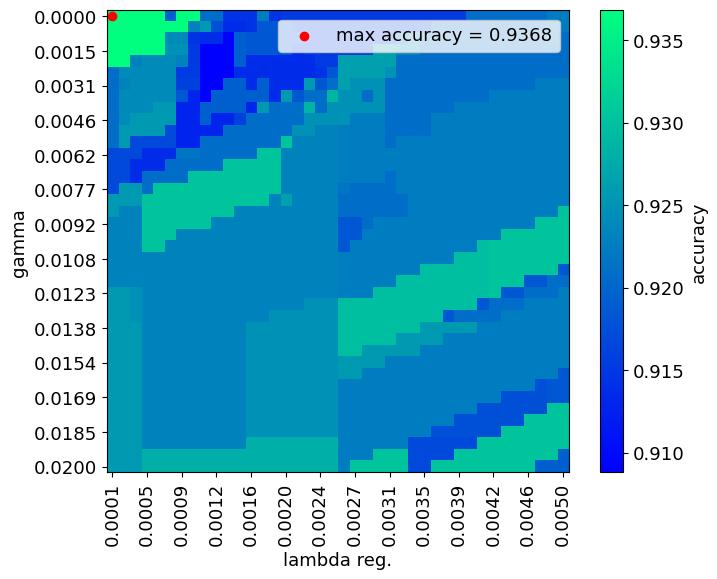

In [64]:

acc_arr_r = np.load(f"Point_1/{float(mi_la)},{ma_la},{float(mi_g)},{float(ma_g)}_lambda_and_gamma.npy")

g_range = np.linspace(mi_g,ma_g,len(acc_arr_r))
la_range = np.linspace(mi_la,ma_la,len(acc_arr_r[0]))

max_idx = np.unravel_index(np.argmax(acc_arr_r), acc_arr_r.shape)
max_value = acc_arr_r[max_idx]

best_gamma = g_range[max_idx[0]]
best_lambda = la_range[max_idx[1]]

print(f"Best accuracy with n_estimators = {best_gamma} and learning rate = {best_lambda:.4f}")

plt.figure(figsize=(8, 6))
plt.imshow(acc_arr_r)
plt.colorbar(label="accuracy", shrink= 1)

plt.scatter(max_idx[1],max_idx[0], color = "r", label = f"max accuracy = {max_value}")

plt.xlabel("lambda reg.")
plt.ylabel("gamma")
plt.yticks(range(len(g_range)), labels=[f'{val:.4f}' for val in g_range])
plt.xticks(range(len(la_range)), labels=[f'{val:.4f}' for val in la_range], rotation = 90)
xticks = plt.xticks()[0] 
yticks = plt.yticks()[0]
plt.xticks(xticks[::3])
plt.yticks(yticks[::3])
plt.legend(loc = "best")

plt.show()

### Searching randomly in the hyperparameter space around the best point founded in the previous steps

In [65]:
np.random.seed(1234)

def search(tra_test, n_test=10):

    "learning_rate=0.4 ,reg_lambda=0.001, n_estimators=40, max_depth = 6, gamma = 0"
    x = [np.array([best_learning_rate ,best_lambda, best_n_estimators, best_gamma])]
    model, acc,_ = tra_test(learning_rate=x[0][0] ,reg_lambda=x[0][1], n_estimators=int(x[0][2]), gamma = x[0][3])
    model_arr = [model]
    acc_arr = [acc]
    
    for i in tqdm(range(n_test), desc = "Processing"):
        model, acc, _ = tra_test(learning_rate=x[i][0] ,reg_lambda=x[i][1], n_estimators=int(x[i][2]), gamma = x[i][3])       
        model_arr.append(model)
        acc_arr.append(acc)
        x.append(np.array([max(0, best_learning_rate + (np.random.uniform()-0.5)*0.05),
                           max(0, best_lambda + (np.random.uniform()-0.5)*0.0005),
                           best_n_estimators + int((np.random.uniform()-0.5)*2),
                           max(0, best_gamma + (np.random.uniform()-0.5)*0.005)]))

    sorted_indices = np.argsort(acc_arr)[::-1]
    model_arr = np.array(model_arr)[sorted_indices]
    acc_arr = np.array(acc_arr)[sorted_indices]
    x = np.array(x)[sorted_indices] 
    return model_arr, acc_arr, x

In [66]:
model_arr, acc_arr, hyper_param = search(make_and_test_xgb_model, n_test = 1000)

Processing: 100%|███████████████████████████████████████████████| 1000/1000 [00:52<00:00, 18.96it/s]


In [67]:
for i in range(5):
    print(f"{acc_arr[i]:.5f}", hyper_param[i])

0.93680 [3.76923077e-01 1.00000000e-04 4.40000000e+01 0.00000000e+00]
0.93680 [3.83617306e-01 4.55057491e-05 4.40000000e+01 6.54690354e-04]
0.93680 [3.61499049e-01 1.61054386e-04 4.40000000e+01 1.42679292e-03]
0.93680 [4.00788710e-01 3.37698183e-04 4.40000000e+01 1.57494101e-03]
0.93680 [3.79064090e-01 2.78064929e-04 4.40000000e+01 2.48476068e-03]


For me the best model is this --> model_arr[0]

In [9]:
best_accuracy = acc_arr[0]
model = model_arr[0]
hyper_par = hyper_param[0]

NameError: name 'acc_arr' is not defined

# 2. Dimensionality reduction
Now we want to observe how the training perform reducing the dimensionality of the feature space.

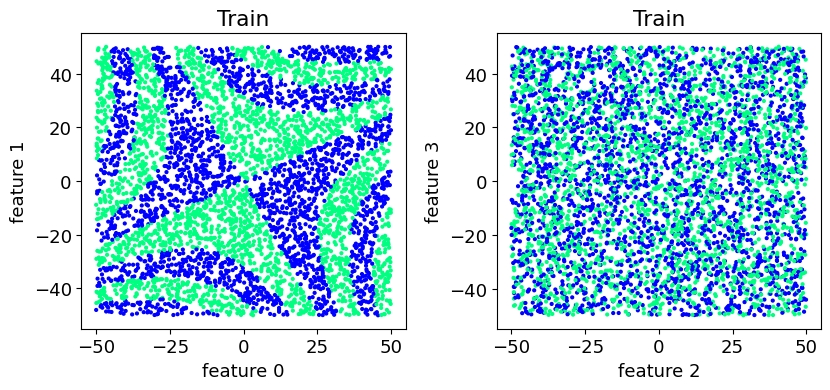

In [5]:
fig,AX = plt.subplots(1,2,figsize=(8.5,4.1))
scat(AX[0],x,y,title="Train")
scat(AX[1],x,y,i=2,j=3,title="Train")

fig.tight_layout()
plt.show()

Generate the training and the test set without one of the feature space dimension.

In [6]:
def remove_dim(dim, data = x):
    return np.delete(data, dim, axis = 1)

x_train_0 = remove_dim(0, data = x_train)
x_test_0 = remove_dim(0, data = x_test)
x_train_1 = remove_dim(1, data = x_train)
x_test_1 = remove_dim(1, data = x_test)
x_train_2 = remove_dim(2, data = x_train)
x_test_2 = remove_dim(2, data = x_test)
x_train_3 = remove_dim(3, data = x_train)
x_test_3 = remove_dim(3, data = x_test)

x_train_arr = [x_train_0, x_train_1, x_train_2, x_train_3]
x_test_arr = [x_test_0, x_test_1, x_test_2, x_test_3]

In [7]:
acc_perf_without_feature = [best_accuracy]

for tr,te in zip(x_train_arr, x_test_arr):
    _, acc = classify(model, x_train = tr, x_test = te)
    acc_perf_without_feature.append(acc)

x_labels = ["All f.", "No f. 1", "No f. 2", "No f. 3", "No f. 4"]

plt.scatter(x_labels, acc_perf_without_feature, zorder = 2)
plt.xlabel("")
plt.ylabel("Accuracy")
plt.grid(zorder = 0)

plt.show()

NameError: name 'best_accuracy' is not defined

As expected removing the first or the second feature of the data results in a sensible worst accuracy respect to the one obtained in the full data case.\
Removing the third or the forth instead slightly change the performance of the model resulting in an accuracy comparable with the original one.

We now exploit the results obtained removing both the third and the forth dimensions.

In [10]:
x_train_23 = remove_dim(3, data = x_train)
x_test_23 = remove_dim(3, data = x_test)
x_train_23 = remove_dim(2, data = x_train_23)
x_test_23 = remove_dim(2, data = x_test_23)

_, acc = classify(model, x_train = x_train_23, x_test = x_test_23)

acc_compl = np.copy(acc_perf_without_feature)
acc_compl = np.append(acc_compl, acc)

x_labels = ["All f.", "No f. 1", "No f. 2", "No f. 3", "No f. 4", "No f. 3&4"]

plt.scatter(x_labels, acc_compl, zorder = 2)
plt.xlabel("")
plt.ylabel("Accuracy")
plt.grid(zorder = 0)

plt.show()

print("\nThe accuracy with the entire dataset is:", best_accuracy,"while the accuracy obtained removing the two last dimensions is:", f"{acc:.4f}")

NameError: name 'model' is not defined

# XGBoost vs NN

In [17]:
# Fraction dataset useds
fractions = [0.05, 0.1, 0.2, 0.5, 0.75]

In [19]:
# Fuction to build a FFNN
def build_ffnn(input_dim, layer_sizes=[16, 8], activation='relu', optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(input_dim,)))
    #model.add(keras.layers.Dense(layer_sizes[0], activation=activation, input_shape=(input_dim,)))
    for size in layer_sizes[1:]:
        model.add(keras.layers.Dense(size, activation=activation))
    model.add(keras.layers.Dense(1, activation='sigmoid')) #The activation for the final layer
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# Search for best FFNN architecture
def tune_ffnn(x_train, y_train, epochs=5):
    param_grid = {
        'layer_sizes': [[16, 8], [32, 16], [64, 32]],
        'activation': ['relu', 'tanh'],
        'optimizer' : ['adam','RMSprop']
    }
    best_score = 0
    best_params = None
    
    for layer_sizes in param_grid['layer_sizes']:
        for activation in param_grid['activation']:
            for optimizer in param_grid['optimizer']:
                kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                acc_ffnn_cv = []
                
                for train_idx, val_idx in kfold.split(x_train, y_train):
                    model = build_ffnn(x_train.shape[1], layer_sizes, activation, optimizer)
                    model.fit(x_train[train_idx], y_train[train_idx], epochs=epochs, batch_size=16, verbose=0)
                    _, acc = model.evaluate(x_train[val_idx], y_train[val_idx], verbose=0)
                    acc_ffnn_cv.append(acc)
                
                mean_acc = np.mean(acc_ffnn_cv)
                if mean_acc > best_score:
                    best_score = mean_acc
                    best_params = {'layer_sizes': layer_sizes, 'activation': activation, 'optimizer':optimizer}
        
    return best_params, best_score

# Funzione per validazione FFNN con cross-validation
def cross_validate_ffnn(x_train, y_train, best_params):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    acc_ffnn_cv = []
    
    for train_idx, val_idx in kfold.split(x_train, y_train):
        model = build_ffnn(x_train.shape[1], best_params['layer_sizes'], best_params['activation'], best_params['optimizer'])
        model.fit(x_train[train_idx], y_train[train_idx], epochs=10, batch_size=16, verbose=0)
        _, acc = model.evaluate(x_train[val_idx], y_train[val_idx], verbose=0)
        acc_ffnn_cv.append(acc)
    
    return np.mean(acc_ffnn_cv), acc_ffnn_cv

In [20]:
# Funzione per validazione con cross-validation
def cross_validate_xgb(x_train, y_train):
    model = xgboost.XGBClassifier(eval_metric='logloss')
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    return np.mean(scores), scores

# Hyperparameter Tuning per XGBoost
def tune_xgb(x_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    grid_search = GridSearchCV(xgboost.XGBClassifier(eval_metric='logloss'), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    return grid_search.best_params_, grid_search.best_score_, pd.DataFrame(grid_search.cv_results_)

In [22]:
# Funzione per elaborare ogni frazione
def process_fraction(frac):
    N_train = int(frac * len(x))
    x_train_cross, x_valid, y_train_cross, y_valid = train_test_split(x, y, train_size=N_train, stratify=y, random_state=42)
    
    acc_xgb, scores_xgb = cross_validate_xgb(x_train_cross, y_train_cross)
    best_ffnn_params, best_ffnn_score = tune_ffnn(x_train_cross, y_train_cross)
    acc_ffnn, scores_ffnn = cross_validate_ffnn(x_train_cross, y_train_cross, best_ffnn_params)
    best_xgb_params, best_xgb_score, xgb_cv_results = tune_xgb(x_train_cross, y_train_cross)
    
    # Test di significatività
    t_stat, p_value = ttest_ind(scores_xgb, scores_ffnn, equal_var=False)
    
    return frac, acc_xgb, acc_ffnn, p_value, best_xgb_params, best_xgb_score, best_ffnn_params, best_ffnn_score, xgb_cv_results

# Paralellizzazione con tqdm applicato al generatore
results = Parallel(n_jobs=-1)(
    delayed(process_fraction)(frac) for frac in tqdm(fractions)
)

# Estrai i risultati (opzionale)
all_xgb_results = [result[-1] for result in results]  # xgb_cv_results
results = [result[:-1] for result in results]  # Tutti gli altri dati

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 75.45it/s]
2025-03-28 15:46:33.511082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-28 15:46:33.511082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-28 15:46:33.511080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743173193.523512  197011 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743173193.523536  197028 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register f

KeyboardInterrupt: 

In [16]:
# Confronto XGBoost vs FFNN con cross-validation e tuning
results = []
all_xgb_results = []

for frac in fractions:
    N_train = int(frac * len(x))
    x_train_cross, x_valid, y_train_cross, y_valid = train_test_split(x, y, train_size=N_train, stratify=y, random_state=42)
    
    acc_xgb, scores_xgb = cross_validate_xgb(x_train_cross, y_train_cross)
    best_ffnn_params, best_ffnn_score = tune_ffnn(x_train_cross, y_train_cross)
    acc_ffnn, scores_ffnn = cross_validate_ffnn(x_train_cross, y_train_cross, best_ffnn_params)
    best_xgb_params, best_xgb_score, xgb_cv_results = tune_xgb(x_train_cross, y_train_cross)
    all_xgb_results.append(xgb_cv_results)
    
    # Test di significatività
    t_stat, p_value = ttest_ind(scores_xgb, scores_ffnn, equal_var=False)
    
    results.append((frac, acc_xgb, acc_ffnn, p_value, best_xgb_params, best_xgb_score, best_ffnn_params, best_ffnn_score))

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7c446cb528e0>
Traceback (most recent call last):
  File "/home/marco/anaconda3/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Visualizzazione dei risultati
fractions_plot = [r[0] for r in results]
acc_xgb_plot = [r[1] for r in results]
acc_ffnn_plot = [r[2] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(fractions_plot, acc_xgb_plot, marker='o', label='XGBoost')
plt.plot(fractions_plot, acc_ffnn_plot, marker='s', label='FFNN')
plt.xlabel("Training Fraction")
plt.ylabel("Cross-Validated Accuracy")
plt.title("XGBoost vs FFNN Performance with Cross-Validation and Hyperparameter Tuning")
plt.legend()
plt.grid()
plt.show()

# Stampare i risultati
for frac, acc_xgb, acc_ffnn, p_value, best_xgb_params, best_xgb_score, best_ffnn_params, best_ffnn_score in results:
    print(f"Training fraction: {frac:.2f} | XGB CV Acc: {acc_xgb:.3f} | FFNN CV Acc: {acc_ffnn:.3f} | p-value: {p_value:.5f}")
    print(f"Best XGBoost params: {best_xgb_params} | Best XGB CV Score: {best_xgb_score:.3f}")
    print(f"Best FFNN params: {best_ffnn_params} | Best FFNN CV Score: {best_ffnn_score:.3f}\n")